# Discontinuous Galerkin Discretizations
We are solving the scalar linear transport problem
Find $u : [0,T] \rightarrow V_D := \{u \in L^2(\Omega), b \cdot \nabla u \in L^2(\Omega), u\restriction_{\Gamma_{in}} = u_D\}$ s.t.
$$\int_\Omega \partial_t uv + b \cdot \nabla uv = \int_\Omega fv \hspace{3em} \forall v \in V_0  := \{u \in L^2(\Omega), b \cdot \nabla u \in L^2(\Omega), u\restriction_{\Gamma_{in}} = 0\}$$

In [2]:
import netgen.gui
%gui tk
import tkinter
from math import pi
from ngsolve import *
from netgen.geom2d import SplineGeometry


In [3]:
geo = SplineGeometry()
geo.AddRectangle( (0, 0), (1, 1), 
                 bcs = ("bottom", "right", "top", "left"))
mesh = Mesh( geo.GenerateMesh(maxh=0.2))



In [4]:
b = CoefficientFunction((1,2))
n = specialcf.normal(mesh.dim)
ubnd = IfPos(x,1,0)

V = L2(mesh,order=2)
u,v = V.TrialFunction(), V.TestFunction()

c = BilinearForm(V)
c += SymbolicBFI( b * grad(u) * v)
c += SymbolicBFI( IfPos( (b*n), 0, (b*n) * (u.Other(ubnd)-u)) * v, element_boundary=True)

gfu_expl = GridFunction(V)
Draw(gfu_expl,mesh,"u_explicit")

res = gfu_expl.vec.CreateVector()
c.Apply(gfu_expl.vec,res)


In [5]:
t = 0
dt = 0.001
tend = 1

while t < tend-0.5*dt:
    c.Apply(gfu_expl.vec,res)
    V.SolveM(CoefficientFunction(1.0),res)
    gfu_expl.vec.data -= dt * res
    t += dt
    Redraw(blocking=True)


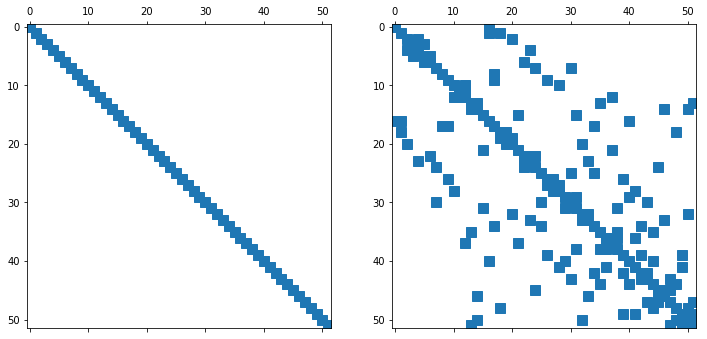

In [6]:
V1 = L2(mesh,order=0)
a1 = BilinearForm(V1)
a1.Assemble()

V2 = L2(mesh,order=0,flags={"dgjumps" : True})
a2 = BilinearForm(V2)
a2.Assemble()

import scipy.sparse as sp
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = (12, 12)

a1.mat.AsVector()[:] = 1 # set every entry to 1
rows,cols,vals = a1.mat.COO()
# had to add this for scipy version 0.17.0 because scipy errors trying to convert
# vals (type <class 'ngsolve.bla.VectorD'>) to int when checking the constructor arguments.  
# I should probably be using pip to intall numpy, scipy, etc...
# rrs = [int(r) for r in rows]
# ccs = [int(c) for c in cols]
# vvs = [float(v) for v in vals]
A1 = sp.csr_matrix((vals,(rows, cols)))
a2.mat.AsVector()[:] = 1 # set every entry to 1
rows,cols,vals = a2.mat.COO()
# rrs = [int(r) for r in rows]
# ccs = [int(c) for c in cols]
# vvs = [float(v) for v in vals]
A2 = sp.csr_matrix((vals,(rows,cols)))
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.spy(A1)
ax2.spy(A2)
plt.show()


In [27]:
print(type(vals))

<class 'ngsolve.bla.VectorD'>
